In [0]:
!pip install fbprophet

In [0]:
import math
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import csv

import matplotlib.pyplot as plt
import pylab
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [0]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 629626)

In [0]:
data3 = pd.read_csv('/content/model3_cash.csv')
holidays = pd.read_csv('/content/HolidaysforModel3 v1.1.csv')

# cust_data = pd.read_csv('/content/model1_cumulative.csv')

In [0]:
data3.head()

,Unnamed: 0,Effective Date,Amount
0,0,1949-02-25,131994.69
1,1,1949-03-01,16665.97
2,2,1949-03-03,1275375.80
3,3,1949-03-05,75407.50
4,4,1949-03-07,78310.72


In [0]:
data3.drop('Unnamed: 0', axis = 1, inplace = True)

In [0]:
data3.head()

,Effective Date,Amount
0,1949-02-25,131994.69
1,1949-03-01,16665.97
2,1949-03-03,1275375.80
3,1949-03-05,75407.50
4,1949-03-07,78310.72


In [0]:
data3 = data3.sort_values('Effective Date', ascending = True)

In [0]:
date_rng = pd.date_range(start=pd.to_datetime(data3['Effective Date'].min()), end=pd.to_datetime(data3['Effective Date'].max()), freq='D')
date_rng

DatetimeIndex(['1949-02-25', '1949-02-26', '1949-02-27', '1949-02-28',
               '1949-03-01', '1949-03-02', '1949-03-03', '1949-03-04',
               '1949-03-05', '1949-03-06',
               ...
               '1952-01-05', '1952-01-06', '1952-01-07', '1952-01-08',
               '1952-01-09', '1952-01-10', '1952-01-11', '1952-01-12',
               '1952-01-13', '1952-01-14'],
              dtype='datetime64[ns]', length=1054, freq='D')

In [0]:
data = pd.DataFrame()
data['Effective Date'] = date_rng
data['Effective Date'] = data['Effective Date'].astype(str)
data3['Effective Date'] = data3['Effective Date'].astype(str)
data = pd.merge(data, data3, how = 'left', on = 'Effective Date')

In [0]:
data.fillna(0, inplace = True)
data['Effective Date'] = pd.to_datetime(data['Effective Date'])
data = data.sort_values('Effective Date', ascending = True)
data.head()

,Effective Date,Amount
0,1949-02-25,131994.69
1,1949-02-26,0.00
2,1949-02-27,0.00
3,1949-02-28,0.00
4,1949-03-01,16665.97


In [0]:
data.columns = ['ds', 'y']
holidays['holidays'] = 'state_holiday'
holidays.columns = ['ds', 'holiday']
holidays.head()

,ds,holiday
0,1949-01-18,state_holiday
1,1949-02-15,state_holiday
2,1949-05-30,state_holiday
3,1949-07-04,state_holiday
4,1949-09-05,state_holiday


In [0]:
def quarter_code(x):
  if x.quarter in [1,3]:
    return 0
  elif x.quarter in [2]:
    return 1
  else:
    return 2
  
def weekofyear_code(x):
  if x.weekofyear in [1,2,3,4,5,6,49,50,51,52]:
    return 0
  elif x.weekofyear in [7,8,9,10,23,24,25,26,27,28,29,30,31,32,33,34,35,36]:
    return 1
  elif x.weekofyear in [11,12,13,14,15,16,17,18,19,20,21,22]:
    return 2
  elif x.weekofyear in [37,38,39]:
    return 3
  elif x.weekofyear in [40,41,42,43,45]:
    return 4
  else:
    return 5
  
def end_features_code(x):
  if x.is_month_start or x.is_month_end:
    return 1
  elif x.is_quarter_start:
    return 2
  elif x.is_quarter_end:
    return 3
  elif x.is_year_start:
    return 4
  elif x.is_year_end:
    return 5
  else:
    return 0

data['quarter_code'] = data['ds'].apply(lambda x: quarter_code(x))

data['dayofweek'] = data['ds'].dt.dayofweek

data['day'] = data['ds'].dt.day

data['month'] = data['ds'].dt.month

data['quarter'] = data['ds'].dt.quarter

data['week_of_month'] = data['ds'].apply(lambda d: (d.day-1) // 7 + 1)

data['weekofyear_code'] = data['ds'].apply(lambda x: weekofyear_code(x))

data['end_code'] = data['ds'].apply(lambda x: end_features_code(x))

data['time_since_for_trend']=(data['ds']-data['ds'].min()).astype(str).apply(lambda x: x.split()[0])

data['is_weekend']=np.where((data['dayofweek']==5)|(data['dayofweek']==6),1,0)

data['is_weekday']=np.where((data['dayofweek']==5)|(data['dayofweek']==6),0,1)

In [0]:
holidays['ds'] = pd.to_datetime(holidays['ds'])
final_holidays_list=list(holidays['ds'].dt.date)

data['is_holiday']=np.nan
data.loc[data['ds'].apply(lambda x: True if x.date() in final_holidays_list else False),'is_holiday_boolean']=1
data['is_holiday_boolean'].fillna(0,inplace=True)

data['weekend_and_holiday']=((data['is_holiday_boolean']==1)|(data['is_weekend']==1)).astype(int)

In [0]:
data['no_of_days_till_next_festival'] = np.nan
data['date_time']=pd.to_datetime(data['ds']).dt.date
data['date_time22']=(data['date_time']-data['date_time'].min()).apply(lambda x: str(x).split(' ')[0]).astype(int)
data=data.sort_values('date_time22')
holidays11=data[data['is_holiday_boolean']==1].sort_values('date_time22')['date_time22'].values.tolist()
data.reset_index(drop=True,inplace=True)
data['no_of_days_till_next_festival']=np.nan

data_index=data.index

current_holiday_index=0
for index in data_index:
    curr_date = data.at[index, 'date_time22']
    if (len(holidays11)==0):
        data.at[index, 'no_of_days_till_next_festival']=-1
    else:
        if curr_date<=holidays11[0]:
            data.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date
        else:
            holidays11.remove(holidays11[0])
            if (len(holidays11)==0):
                data.at[index, 'no_of_days_till_next_festival']=-1
            else:
                data.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date

In [0]:
## No of days for All holidays(holidays+weekends)
data['no_of_days_till_next_holiday'] = np.nan
holidays_all=data[data['weekend_and_holiday']==1].sort_values('date_time22')['date_time22'].values.tolist()
data.reset_index(drop=True,inplace=True)
holidays_all=sorted(list(set(holidays_all)))
data=data.sort_values('date_time22')
data_index=data.index
current_holiday_index=0
for index in data_index:
    curr_date = data.at[index, 'date_time22']
    if (len(holidays_all)==0):
        data.at[index, 'no_of_days_till_next_holiday']=-1
    else:
        if curr_date<=holidays_all[0]:
            data.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date
        else:
            holidays_all.remove(holidays_all[0])
            if (len(holidays_all)==0):
                data.at[index, 'no_of_days_till_next_holiday']=-1
            else:
                data.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date

In [0]:
## Past holidays
data['no_of_days_past_last_festival'] = np.nan
data=data.sort_values('date_time22')
holidays11=data[data['is_holiday_boolean']==1].sort_values('date_time22')['date_time22'].values.tolist()
data.reset_index(drop=True,inplace=True)
for index in data_index:
    curr_date = data.at[index, 'date_time22']
    if curr_date<holidays11[0]:
        data.at[index, 'no_of_days_past_last_festival']=-1
    elif curr_date==holidays11[0]:
        data.at[index, 'no_of_days_past_last_festival']=0
    else:
        data.at[index, 'no_of_days_past_last_festival']=curr_date-holidays11[0]
        if (len(holidays11)>1):
            if (holidays11[1]==(curr_date+1)):
                holidays11.remove(holidays11[0])

data['no_of_days_past_last_holiday'] = np.nan
holidays_all=data[data['weekend_and_holiday']==1].sort_values('date_time22')['date_time22'].values.tolist()
data.reset_index(drop=True,inplace=True)
holidays_all=sorted(list(set(holidays_all)))
data=data.sort_values('date_time22')

for index in data_index:
    curr_date = data.at[index, 'date_time22']
    if curr_date<holidays_all[0]:
        data.at[index, 'no_of_days_past_last_holiday']=-1
    elif curr_date==holidays_all[0]:
        data.at[index, 'no_of_days_past_last_holiday']=0
        if (len(holidays_all)>1):
            if (holidays_all[1]==(curr_date+1)):
                holidays_all.remove(holidays_all[0])
    else:
        data.at[index, 'no_of_days_past_last_holiday']=curr_date-holidays_all[0]
        if (len(holidays_all)>1):
            if (holidays_all[1]==(curr_date+1)):
                holidays_all.remove(holidays_all[0])

In [0]:
data_index=data.index

data['is_peak']=np.where(data['y']>(data['y'].median()+(2*data['y'].std())),1,0)

In [0]:
# no of days from last peak
data['no_of_days_from_last_peak']=np.nan
peaks_all=data[data['is_peak']==1].sort_values('date_time22')['date_time22'].values.tolist()
data.reset_index(drop=True,inplace=True)
peaks_all=sorted(list(set(peaks_all)))
data=data.sort_values('date_time22')

for index in data_index:
    curr_date = data.at[index, 'date_time22']
    if curr_date<peaks_all[0]:
        data.at[index, 'no_of_days_from_last_peak']=-1
    elif curr_date==peaks_all[0]:
        data.at[index, 'no_of_days_from_last_peak']=0
        if (len(peaks_all)>1):
            if (peaks_all[1]==(curr_date+1)):
                peaks_all.remove(peaks_all[0])
    else:
        data.at[index, 'no_of_days_from_last_peak']=curr_date-peaks_all[0]
        if (len(peaks_all)>1):
            if (peaks_all[1]==(curr_date+1)):
                peaks_all.remove(peaks_all[0])

In [0]:
for i in range(3, 8):
    data['rolling_Amount_mean_' + str(i)] = data['y'].shift().rolling(i).mean()
    data['rolling_Amount_std_' + str(i)] = data['y'].shift().rolling(i).std()
    data['rolling_Amount_mean_' + str(i)] = data['rolling_Amount_mean_' + str(i)].fillna(0)
    data['rolling_Amount_std_' + str(i)] = data['rolling_Amount_std_' + str(i)].fillna(0)

In [0]:
for i in range(1, 6):
    data['last_T' + str(i)] = data['y'].shift(i)
    data['last_T' + str(i)] = data['last_T' + str(i)].fillna(0)

In [0]:
data.head()

,ds,y,quarter_code,dayofweek,day,month,quarter,week_of_month,weekofyear_code,end_code,time_since_for_trend,is_weekend,is_weekday,is_holiday,is_holiday_boolean,...,rolling_Amount_mean_3,rolling_Amount_std_3,rolling_Amount_mean_4,rolling_Amount_std_4,rolling_Amount_mean_5,rolling_Amount_std_5,rolling_Amount_mean_6,rolling_Amount_std_6,rolling_Amount_mean_7,rolling_Amount_std_7,last_T1,last_T2,last_T3,last_T4,last_T5
0,1949-02-25,131994.69,0,4,25,2,1,4,1,0,0,0,1,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
1,1949-02-26,0.00,0,5,26,2,1,4,1,0,1,1,0,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,131994.69,0.00,0.00,0.00,0.0
2,1949-02-27,0.00,0,6,27,2,1,4,1,0,2,1,0,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,131994.69,0.00,0.00,0.0
3,1949-02-28,0.00,0,0,28,2,1,4,1,1,3,0,1,NaN,0.0,...,43998.23,76207.169803,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,131994.69,0.00,0.0
4,1949-03-01,16665.97,0,1,1,3,1,1,1,1,4,0,1,NaN,0.0,...,0.00,0.000000,32998.6725,65997.345,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,131994.69,0.0


In [0]:
data['ds'].iloc[:int(0.80*len(data))].tail(1)

842   1951-06-17
Name: ds, dtype: datetime64[ns]

In [0]:
train = data[data['ds'] <= '1951-06-17']
test = data[data['ds'] > '1951-06-17']

In [0]:
train.shape, test.shape

((843, 39), (211, 39))

In [0]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 3, 1)
    df[variable].hist()

    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

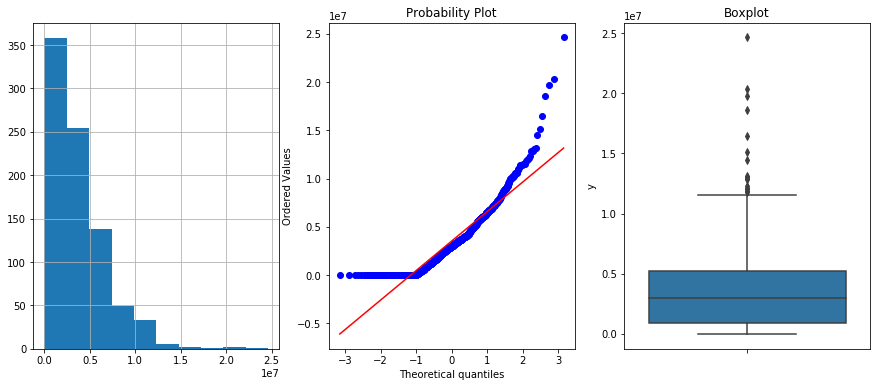

In [0]:
diagnostic_plots(train, 'y')

In [0]:
stat, p = stats.normaltest(train['y'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=262.410, p=0.000
Data does not look Gaussian (reject H0)


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 39 columns):
ds                               843 non-null datetime64[ns]
y                                843 non-null float64
quarter_code                     843 non-null int64
dayofweek                        843 non-null int64
day                              843 non-null int64
month                            843 non-null int64
quarter                          843 non-null int64
week_of_month                    843 non-null int64
weekofyear_code                  843 non-null int64
end_code                         843 non-null int64
time_since_for_trend             843 non-null object
is_weekend                       843 non-null int64
is_weekday                       843 non-null int64
is_holiday                       0 non-null float64
is_holiday_boolean               843 non-null float64
weekend_and_holiday              843 non-null int64
no_of_days_till_next_festival    843 non-null flo

In [0]:
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])

In [0]:
train.head()

,ds,y,quarter_code,dayofweek,day,month,quarter,week_of_month,weekofyear_code,end_code,time_since_for_trend,is_weekend,is_weekday,is_holiday,is_holiday_boolean,...,rolling_Amount_mean_3,rolling_Amount_std_3,rolling_Amount_mean_4,rolling_Amount_std_4,rolling_Amount_mean_5,rolling_Amount_std_5,rolling_Amount_mean_6,rolling_Amount_std_6,rolling_Amount_mean_7,rolling_Amount_std_7,last_T1,last_T2,last_T3,last_T4,last_T5
0,1949-02-25,131994.69,0,4,25,2,1,4,1,0,0,0,1,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
1,1949-02-26,0.00,0,5,26,2,1,4,1,0,1,1,0,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,131994.69,0.00,0.00,0.00,0.0
2,1949-02-27,0.00,0,6,27,2,1,4,1,0,2,1,0,NaN,0.0,...,0.00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,131994.69,0.00,0.00,0.0
3,1949-02-28,0.00,0,0,28,2,1,4,1,1,3,0,1,NaN,0.0,...,43998.23,76207.169803,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,131994.69,0.00,0.0
4,1949-03-01,16665.97,0,1,1,3,1,1,1,1,4,0,1,NaN,0.0,...,0.00,0.000000,32998.6725,65997.345,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,131994.69,0.0


In [0]:
(train['y'] < 0).sum()

14

In [0]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

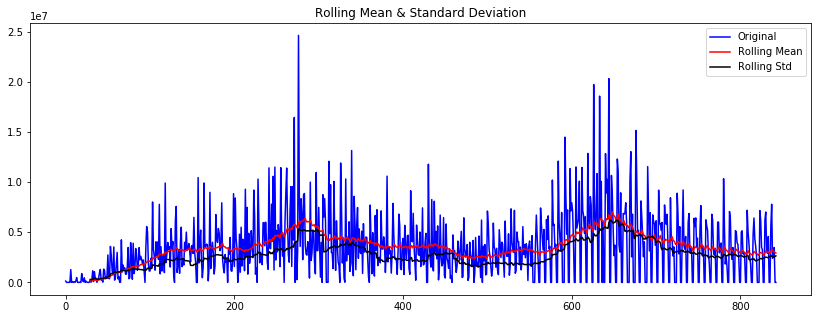

<Results of Dickey-Fuller Test>
Test Statistic                  -2.792841
p-value                          0.059304
#Lags Used                      20.000000
Number of Observations Used    822.000000
Critical Value (1%)             -3.438330
Critical Value (5%)             -2.865063
Critical Value (10%)            -2.568646
dtype: float64


In [0]:
test_stationarity(train['y'])

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 39 columns):
ds                               843 non-null datetime64[ns]
y                                843 non-null float64
quarter_code                     843 non-null int64
dayofweek                        843 non-null int64
day                              843 non-null int64
month                            843 non-null int64
quarter                          843 non-null int64
week_of_month                    843 non-null int64
weekofyear_code                  843 non-null int64
end_code                         843 non-null int64
time_since_for_trend             843 non-null object
is_weekend                       843 non-null int64
is_weekday                       843 non-null int64
is_holiday                       0 non-null float64
is_holiday_boolean               843 non-null float64
weekend_and_holiday              843 non-null int64
no_of_days_till_next_festival    843 non-null flo

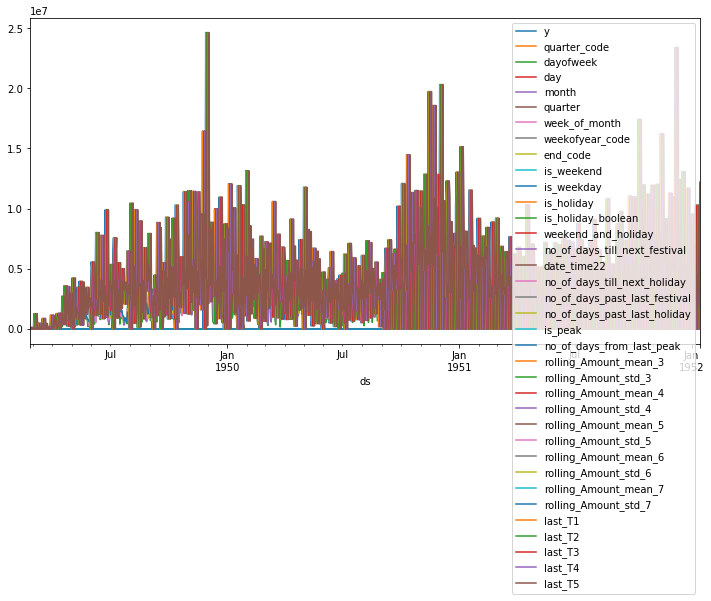

In [0]:
data.set_index('ds').plot(figsize = (12, 6))

In [0]:
# holidays.drop('holiday', axis = 1, inplace = True)

In [0]:
holidays.head()

,ds,holiday
0,1949-01-18,state_holiday
1,1949-02-15,state_holiday
2,1949-05-30,state_holiday
3,1949-07-04,state_holiday
4,1949-09-05,state_holiday


In [0]:
holiday_list = holidays['ds'].tolist()

In [0]:
final_data = data.copy()
final_data.columns = data.columns

In [0]:
test_dates = test.drop('y', axis = 1)
test_dates.reset_index(inplace = True, drop = True)
test_dates.head()

,ds,quarter_code,dayofweek,day,month,quarter,week_of_month,weekofyear_code,end_code,time_since_for_trend,is_weekend,is_weekday,is_holiday,is_holiday_boolean,weekend_and_holiday,...,rolling_Amount_mean_3,rolling_Amount_std_3,rolling_Amount_mean_4,rolling_Amount_std_4,rolling_Amount_mean_5,rolling_Amount_std_5,rolling_Amount_mean_6,rolling_Amount_std_6,rolling_Amount_mean_7,rolling_Amount_std_7,last_T1,last_T2,last_T3,last_T4,last_T5
0,1951-06-18,1,0,18,6,2,3,1,0,843,0,1,NaN,0.0,0,...,1.158586e+06,2.006729e+06,1.541143e+06,1.808326e+06,1714256.902,1.613187e+06,2.726841e+06,2.869471e+06,3.123859e+06,2.822218e+06,0.00,-1.364242e-12,3.475757e+06,2.688815e+06,2.406712e+06
1,1951-06-19,1,1,19,6,2,3,1,0,844,0,1,NaN,0.0,0,...,2.316978e+06,4.013123e+06,2.606673e+06,3.327531e+06,2623101.126,2.881961e+06,2.587036e+06,2.579217e+06,3.330283e+06,3.067661e+06,6950933.48,0.000000e+00,-1.364242e-12,3.475757e+06,2.688815e+06
2,1951-06-20,1,2,20,6,2,3,1,0,845,0,1,NaN,0.0,0,...,4.771700e+06,4.137576e+06,3.578775e+06,4.135856e+06,3558171.604,3.582052e+06,3.413279e+06,3.223483e+06,3.269484e+06,2.967116e+06,7364167.12,6.950933e+06,0.000000e+00,-1.364242e-12,3.475757e+06
3,1951-06-21,1,3,21,6,2,3,1,0,846,0,1,NaN,0.0,0,...,5.559535e+06,2.775544e+06,4.169652e+06,3.586485e+06,3335721.272,3.622755e+06,3.359061e+06,3.240795e+06,3.263311e+06,2.969254e+06,2363505.76,7.364167e+06,6.950933e+06,0.000000e+00,-1.364242e-12
4,1951-06-22,1,4,22,6,2,4,1,0,847,0,1,NaN,0.0,0,...,4.224590e+06,2.734513e+06,4.906176e+06,2.615966e+06,3924940.582,3.153819e+06,3.270784e+06,3.244192e+06,3.300066e+06,2.962542e+06,2946096.55,2.363506e+06,7.364167e+06,6.950933e+06,0.000000e+00


In [0]:
full_test_dates = pd.concat([train['ds'], test_dates['ds']])
full_test_dates = pd.DataFrame({'ds': full_test_dates})
full_test_dates.reset_index(drop = True, inplace = True)
full_test_dates = full_test_dates.sort_values('ds', ascending = True)
full_test_dates.head()

,ds
0,1949-02-25
1,1949-02-26
2,1949-02-27
3,1949-02-28
4,1949-03-01


In [0]:
train.columns

Index(['ds', 'y', 'quarter_code', 'dayofweek', 'day', 'month', 'quarter',
       'week_of_month', 'weekofyear_code', 'end_code', 'time_since_for_trend',
       'is_weekend', 'is_weekday', 'is_holiday', 'is_holiday_boolean',
       'weekend_and_holiday', 'no_of_days_till_next_festival', 'date_time',
       'date_time22', 'no_of_days_till_next_holiday',
       'no_of_days_past_last_festival', 'no_of_days_past_last_holiday',
       'is_peak', 'no_of_days_from_last_peak', 'rolling_Amount_mean_3',
       'rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
       'rolling_Amount_mean_5', 'rolling_Amount_std_5',
       'rolling_Amount_mean_6', 'rolling_Amount_std_6',
       'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2',
       'last_T3', 'last_T4', 'last_T5'],
      dtype='object')

In [0]:
train = train[['ds', 'y', 'day', 'quarter_code', 'dayofweek', 'weekofyear_code', 'end_code', 'time_since_for_trend', 'month',
              'quarter', 'week_of_month', 'is_weekend', 'is_weekday','rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
          'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6', 'rolling_Amount_std_6',
          'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5',
          'is_holiday_boolean','weekend_and_holiday','no_of_days_till_next_festival', 
          'no_of_days_till_next_holiday','no_of_days_past_last_festival','no_of_days_past_last_holiday', 
          'no_of_days_from_last_peak']]
test_dates = test_dates[['ds', 'day', 'quarter_code', 'dayofweek', 'weekofyear_code', 'end_code','time_since_for_trend', 'month',
              'quarter', 'week_of_month', 'is_weekend', 'is_weekday','rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
          'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6', 'rolling_Amount_std_6',
          'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5',
          'is_holiday_boolean','weekend_and_holiday','no_of_days_till_next_festival', 
          'no_of_days_till_next_holiday','no_of_days_past_last_festival','no_of_days_past_last_holiday', 
          'no_of_days_from_last_peak']]
train.isnull().sum()

ds                               0
y                                0
day                              0
quarter_code                     0
dayofweek                        0
weekofyear_code                  0
end_code                         0
time_since_for_trend             0
month                            0
quarter                          0
week_of_month                    0
is_weekend                       0
is_weekday                       0
rolling_Amount_mean_3            0
rolling_Amount_std_3             0
rolling_Amount_mean_4            0
rolling_Amount_std_4             0
rolling_Amount_mean_5            0
rolling_Amount_std_5             0
rolling_Amount_mean_6            0
rolling_Amount_std_6             0
rolling_Amount_mean_7            0
rolling_Amount_std_7             0
last_T1                          0
last_T2                          0
last_T3                          0
last_T4                          0
last_T5                          0
is_holiday_boolean  

In [0]:
train.shape, test_dates.shape

((843, 35), (211, 34))

In [0]:
cp_prior_vals = np.arange(1, 4, 0.25)
seas_prior_vals = np.arange(1, 4, 0.25)

cp_prior_vals

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75])

In [0]:
train.columns

Index(['ds', 'y', 'day', 'quarter_code', 'dayofweek', 'weekofyear_code',
       'end_code', 'time_since_for_trend', 'month', 'quarter', 'week_of_month',
       'is_weekend', 'is_weekday', 'rolling_Amount_mean_3',
       'rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
       'rolling_Amount_mean_5', 'rolling_Amount_std_5',
       'rolling_Amount_mean_6', 'rolling_Amount_std_6',
       'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2',
       'last_T3', 'last_T4', 'last_T5', 'is_holiday_boolean',
       'weekend_and_holiday', 'no_of_days_till_next_festival',
       'no_of_days_till_next_holiday', 'no_of_days_past_last_festival',
       'no_of_days_past_last_holiday', 'no_of_days_from_last_peak'],
      dtype='object')

In [0]:
holidays.head()

,ds,holiday
0,1949-01-18,state_holiday
1,1949-02-15,state_holiday
2,1949-05-30,state_holiday
3,1949-07-04,state_holiday
4,1949-09-05,state_holiday


In [0]:
mae_scores = []
rmse_scores = []

for i in range(10):
  my_model = Prophet(growth = 'linear', holidays = holidays, changepoint_prior_scale = 5 ** cp_prior_vals[i],
                    weekly_seasonality = False)
  my_model.add_seasonality(name = 'weekly', period = 7, fourier_order = 6)
  
  my_model.add_regressor('day')
  my_model.add_regressor('quarter_code')
  my_model.add_regressor('dayofweek')
  my_model.add_regressor('weekofyear_code')
  my_model.add_regressor('end_code')
  my_model.add_regressor('month')
  my_model.add_regressor('quarter')
  my_model.add_regressor('week_of_month')
  my_model.add_regressor('time_since_for_trend')
  my_model.add_regressor('is_weekend')
  my_model.add_regressor('is_weekday')
  my_model.add_regressor('rolling_Amount_mean_3')
  my_model.add_regressor('rolling_Amount_mean_4')
  my_model.add_regressor('rolling_Amount_mean_5')
  my_model.add_regressor('rolling_Amount_mean_6')
  my_model.add_regressor('rolling_Amount_mean_7')
  my_model.add_regressor('rolling_Amount_std_3')
  my_model.add_regressor('rolling_Amount_std_4')
  my_model.add_regressor('rolling_Amount_std_5')
  my_model.add_regressor('rolling_Amount_std_6')
  my_model.add_regressor('rolling_Amount_std_7')
  my_model.add_regressor('last_T1')
  my_model.add_regressor('last_T2')
  my_model.add_regressor('last_T3')
  my_model.add_regressor('last_T4')
  my_model.add_regressor('last_T5')
  my_model.add_regressor('is_holiday_boolean')
  my_model.add_regressor('weekend_and_holiday')
  my_model.add_regressor('no_of_days_till_next_festival')
  my_model.add_regressor('no_of_days_till_next_holiday')
  my_model.add_regressor('no_of_days_past_last_festival')
  my_model.add_regressor('no_of_days_past_last_holiday')
  my_model.add_regressor('no_of_days_from_last_peak')
  
  my_model.fit(train)
  
  forecast = my_model.predict(test_dates)
  
  fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
  
  fc['weekday'] = fc['ds'].dt.dayofweek
  fc['is_weekend'] = np.where(fc['weekday'] > 5, 1, 0)
  fc['yhat'] = np.where(fc['is_weekend'] == 1, 0, fc['yhat'])

  fc.drop(['weekday', 'is_weekend'], axis = 1, inplace = True)
  
  fc['yhat'] = np.where(fc['ds'].isin(holiday_list), 0, fc['yhat'])
  
  mae = mean_absolute_error(test['y'], fc['yhat'])
  rmse = np.sqrt(mean_squared_error(test['y'], fc['yhat']))
  
  mae_scores.append(mae)
  rmse_scores.append(rmse)
  
print(min(mae_scores), np.argmin(mae_scores))
print(min(rmse_scores), np.argmin(rmse_scores))

1537352.6590265457 0
2610926.72751289 0


In [0]:
optimum_cp_prior_value = 5 ** cp_prior_vals[np.argmin(mae_scores)]
optimum_cp_prior_value

5.0

In [0]:
# unique_customers = list(cust_data['cust_id'].unique())

# final_test_preds = pd.DataFrame()

# forecast_date_rng = pd.date_range(start='2007-10-31', end='2008-04-27', freq='D')

# for i in unique_customers:
#   temp = pd.DataFrame()
#   temp = cust_data[cust_data['cust_id'] == i]
  
#   temp.drop('cust_id', axis = 1, inplace = True)
  
#   temp['Effective Date'] = pd.to_datetime(temp['Effective Date'])
  
#   temp = temp.sort_values('Effective Date', ascending = True)
  
#   date_rng = pd.date_range(start=pd.to_datetime(temp['Effective Date'].min()),
#                            end=pd.to_datetime(temp['Effective Date'].max()), freq='D')
  
#   temp1 = pd.DataFrame()
#   temp1['Effective Date'] = date_rng
#   temp1['Effective Date'] = temp1['Effective Date'].astype(str)
#   temp['Effective Date'] = temp['Effective Date'].astype(str)
#   temp1 = pd.merge(temp1, temp, how = 'left', on = 'Effective Date')
  
#   temp1.fillna(0, inplace = True)
#   temp1['Effective Date'] = pd.to_datetime(temp1['Effective Date'])
#   temp1 = temp1.sort_values('Effective Date', ascending = True)
  
#   temp1.columns = ['ds', 'y']
  
#   real_dates = pd.DataFrame({'ds': forecast_date_rng})
  
#   my_model = Prophet(growth = 'linear', holidays = holidays, changepoint_prior_scale = 30)
#   my_model.fit(temp1)
  
#   forecast = my_model.predict(real_dates)
  
#   fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
  
#   fc['weekday'] = fc['ds'].dt.dayofweek
#   fc['is_weekend'] = np.where(fc['weekday'] > 5, 1, 0)
#   fc['yhat'] = np.where(fc['is_weekend'] == 1, 0, fc['yhat'])

#   fc.drop(['weekday', 'is_weekend'], axis = 1, inplace = True)
  
#   fc['yhat'] = np.where(fc['ds'].isin(holiday_list), 0, fc['yhat'])
  
#   final_test_preds[str(i) + 'preds'] = fc['yhat']
  
# final_test_preds['Amount'] = final_test_preds.sum(axis = 1)

# predictions = pd.DataFrame()
# predictions['Effective Date'] = forecast_date_rng
# predictions['Total Cash'] = final_test_preds['Amount']

# predictions.to_csv('model1_cust.csv', index = False)

# final_test_preds.head()

  
# #   print(mean_absolute_error(test['Amount'], fc['yhat']), np.sqrt(mean_squared_error(test['Amount'], fc['yhat'])))

In [0]:
final_features = pd.read_csv('/content/features3.csv')

In [0]:
final_features.shape

(180, 31)

In [0]:
final_features.head()

,rolling_Amount_mean_3,rolling_Amount_std_3,rolling_Amount_mean_4,rolling_Amount_std_4,rolling_Amount_mean_5,rolling_Amount_std_5,rolling_Amount_mean_6,rolling_Amount_std_6,rolling_Amount_mean_7,rolling_Amount_std_7,last_T1,last_T2,last_T3,last_T4,last_T5,...,day_of_month,month,quarter,week_of_year,week_of_month,time_since_for_trend,is_weekend,is_weekday,is_holiday_boolean,weekend_and_holiday,no_of_days_till_next_festival,no_of_days_till_next_holiday,no_of_days_past_last_festival,no_of_days_past_last_holiday,no_of_days_from_last_peak
0,4.066971e+06,7.044200e+06,3.525143e+06,5.852761e+06,3549183.594,5.068925e+06,3.291043e+06,4.577665e+06,3.819166e+06,4.406235e+06,12200911.99,0.00,0.00,1899659.93,3645346.05,...,15,1,1,3,3,1054,0,1,0,0,6,4,14,2,1
1,6.120288e+06,6.100553e+06,4.590216e+06,5.845994e+06,4052104.884,5.203802e+06,3.984312e+06,4.657383e+06,3.700887e+06,4.317212e+06,6159952.50,12200911.99,0.00,0.00,1899659.93,...,16,1,1,3,3,1055,0,1,0,0,5,3,15,3,2
2,7.172040e+06,4.606975e+06,5.379030e+06,5.197020e+06,4303223.748,5.103289e+06,3.902630e+06,4.668800e+06,3.865875e+06,4.263121e+06,3155254.25,6159952.50,12200911.99,0.00,0.00,...,17,1,1,3,3,1056,0,1,0,0,4,2,16,4,3
3,4.417183e+06,1.558993e+06,6.363115e+06,4.094742e+06,5090492.398,4.546761e+06,4.242077e+06,4.566977e+06,3.907446e+06,4.262031e+06,3936343.25,3155254.25,6159952.50,12200911.99,0.00,...,18,1,1,3,3,1057,0,1,0,0,3,1,17,5,4
4,3.846974e+06,6.516478e+05,4.425219e+06,1.273014e+06,5980357.398,3.647973e+06,4.983631e+06,4.075162e+06,4.271684e+06,4.169796e+06,4449325.00,3936343.25,3155254.25,6159952.50,12200911.99,...,19,1,1,3,3,1058,1,0,0,1,2,0,18,0,5


In [0]:
final_data.shape

(1054, 39)

In [0]:
date_rng = pd.date_range(start='1952-01-15', end='1952-07-12', freq='D')

In [0]:
final_features = pd.read_csv('/content/features3.csv')
final_features = final_features.apply(lambda x: pd.to_numeric(x), axis=0)

In [0]:
real_dates = pd.DataFrame({'ds': date_rng})

real_dates['quarter_code'] = real_dates['ds'].apply(lambda x: quarter_code(x))

real_dates['dayofweek'] = real_dates['ds'].dt.dayofweek

real_dates['day'] = real_dates['ds'].dt.day

real_dates['month'] = real_dates['ds'].dt.month

real_dates['quarter'] = real_dates['ds'].dt.quarter

real_dates['week_of_month'] = real_dates['ds'].apply(lambda d: (d.day-1) // 7 + 1)

real_dates['weekofyear_code'] = real_dates['ds'].apply(lambda x: weekofyear_code(x))

real_dates['end_code'] = real_dates['ds'].apply(lambda x: end_features_code(x))

final_real_dates = pd.concat([real_dates, final_features], axis = 1)

In [0]:
final_real_dates.shape

(180, 40)

In [0]:
li = ['ds', 'day', 'quarter_code', 'dayofweek', 'weekofyear_code', 'end_code','time_since_for_trend', 'month',
              'quarter', 'week_of_month', 'is_weekend', 'is_weekday','rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
          'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6', 'rolling_Amount_std_6',
          'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5',
          'is_holiday_boolean','weekend_and_holiday','no_of_days_till_next_festival', 
          'no_of_days_till_next_holiday','no_of_days_past_last_festival','no_of_days_past_last_holiday', 
          'no_of_days_from_last_peak']

In [0]:
final_real_dates = final_real_dates[list(set(li))]

In [0]:
final_data = final_data[['ds', 'y', 'day', 'quarter_code', 'dayofweek', 'weekofyear_code', 'end_code','time_since_for_trend', 'month',
              'quarter', 'week_of_month', 'is_weekend', 'is_weekday','rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
          'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6', 'rolling_Amount_std_6',
          'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5',
          'is_holiday_boolean','weekend_and_holiday','no_of_days_till_next_festival', 
          'no_of_days_till_next_holiday','no_of_days_past_last_festival','no_of_days_past_last_holiday', 
          'no_of_days_from_last_peak']]

In [0]:
final_real_dates = final_real_dates.T.drop_duplicates().T

In [0]:
final_data.shape

(1054, 35)

In [0]:
final_real_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 34 columns):
last_T5                          180 non-null object
rolling_Amount_std_7             180 non-null object
rolling_Amount_std_3             180 non-null object
no_of_days_till_next_festival    180 non-null object
week_of_month                    180 non-null object
last_T2                          180 non-null object
is_holiday_boolean               180 non-null object
rolling_Amount_mean_5            180 non-null object
rolling_Amount_mean_3            180 non-null object
last_T3                          180 non-null object
last_T1                          180 non-null object
no_of_days_past_last_holiday     180 non-null object
rolling_Amount_mean_4            180 non-null object
quarter                          180 non-null object
ds                               180 non-null object
last_T4                          180 non-null object
rolling_Amount_std_4             180 non-null o

In [0]:
final_real_dates.head()

,last_T5,rolling_Amount_std_7,rolling_Amount_std_3,no_of_days_till_next_festival,week_of_month,last_T2,is_holiday_boolean,rolling_Amount_mean_5,rolling_Amount_mean_3,last_T3,last_T1,no_of_days_past_last_holiday,rolling_Amount_mean_4,quarter,ds,...,end_code,no_of_days_from_last_peak,weekofyear_code,rolling_Amount_mean_7,quarter_code,rolling_Amount_std_6,is_weekday,is_weekend,rolling_Amount_mean_6,day,rolling_Amount_std_5,time_since_for_trend,weekend_and_holiday,month,dayofweek
0,3.64535e+06,4.40624e+06,7.0442e+06,6,3,0,0,3.54918e+06,4.06697e+06,0,1.22009e+07,2,3.52514e+06,1,1952-01-15 00:00:00,...,0,1,0,3.81917e+06,0,4.57767e+06,1,0,3.29104e+06,15,5.06892e+06,1054,0,1,1
1,1.89966e+06,4.31721e+06,6.10055e+06,5,3,1.22009e+07,0,4.0521e+06,6.12029e+06,0,6.15995e+06,3,4.59022e+06,1,1952-01-16 00:00:00,...,0,2,0,3.70089e+06,0,4.65738e+06,1,0,3.98431e+06,16,5.2038e+06,1055,0,1,2
2,0,4.26312e+06,4.60698e+06,4,3,6.15995e+06,0,4.30322e+06,7.17204e+06,1.22009e+07,3.15525e+06,4,5.37903e+06,1,1952-01-17 00:00:00,...,0,3,0,3.86587e+06,0,4.6688e+06,1,0,3.90263e+06,17,5.10329e+06,1056,0,1,3
3,0,4.26203e+06,1.55899e+06,3,3,3.15525e+06,0,5.09049e+06,4.41718e+06,6.15995e+06,3.93634e+06,5,6.36312e+06,1,1952-01-18 00:00:00,...,0,4,0,3.90745e+06,0,4.56698e+06,1,0,4.24208e+06,18,4.54676e+06,1057,0,1,4
4,1.22009e+07,4.1698e+06,651648,2,3,3.93634e+06,0,5.98036e+06,3.84697e+06,3.15525e+06,4.44932e+06,0,4.42522e+06,1,1952-01-19 00:00:00,...,0,5,0,4.27168e+06,0,4.07516e+06,0,1,4.98363e+06,19,3.64797e+06,1058,1,1,5


In [0]:
final_data.shape, final_real_dates.shape

((1054, 35), (180, 34))

In [0]:
final_model = Prophet(growth = 'linear', holidays = holidays, changepoint_prior_scale = 30,
                    weekly_seasonality = False)
final_model.add_seasonality(name = 'weekly', period = 7, fourier_order = 6)

final_model.add_regressor('day')
final_model.add_regressor('quarter_code')
final_model.add_regressor('dayofweek')
final_model.add_regressor('weekofyear_code')
final_model.add_regressor('end_code')
final_model.add_regressor('month')
final_model.add_regressor('quarter')
final_model.add_regressor('week_of_month')
final_model.add_regressor('time_since_for_trend')
final_model.add_regressor('is_weekend')
final_model.add_regressor('is_weekday')
final_model.add_regressor('rolling_Amount_mean_3')
final_model.add_regressor('rolling_Amount_mean_4')
final_model.add_regressor('rolling_Amount_mean_5')
final_model.add_regressor('rolling_Amount_mean_6')
final_model.add_regressor('rolling_Amount_mean_7')
final_model.add_regressor('rolling_Amount_std_3')
final_model.add_regressor('rolling_Amount_std_4')
final_model.add_regressor('rolling_Amount_std_5')
final_model.add_regressor('rolling_Amount_std_6')
final_model.add_regressor('rolling_Amount_std_7')
final_model.add_regressor('last_T1')
final_model.add_regressor('last_T2')
final_model.add_regressor('last_T3')
final_model.add_regressor('last_T4')
final_model.add_regressor('last_T5')
final_model.add_regressor('is_holiday_boolean')
final_model.add_regressor('weekend_and_holiday')
final_model.add_regressor('no_of_days_till_next_festival')
final_model.add_regressor('no_of_days_till_next_holiday')
final_model.add_regressor('no_of_days_past_last_festival')
final_model.add_regressor('no_of_days_past_last_holiday')
final_model.add_regressor('no_of_days_from_last_peak')

final_model.fit(final_data)

In [0]:
final_forecast = final_model.predict(final_real_dates)

final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
173,1952-07-06,5.659370e+05,-1.386640e+07,1.605837e+07
174,1952-07-07,7.421001e+06,-7.301143e+06,2.255599e+07
175,1952-07-08,5.008799e+06,-9.175754e+06,2.056421e+07
176,1952-07-09,3.438891e+06,-1.147874e+07,1.903942e+07
177,1952-07-10,2.542289e+06,-1.231041e+07,1.814777e+07
178,1952-07-11,3.525679e+06,-1.139501e+07,1.884858e+07
179,1952-07-12,-2.247886e+05,-1.539566e+07,1.522265e+07


In [0]:
final = final_forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

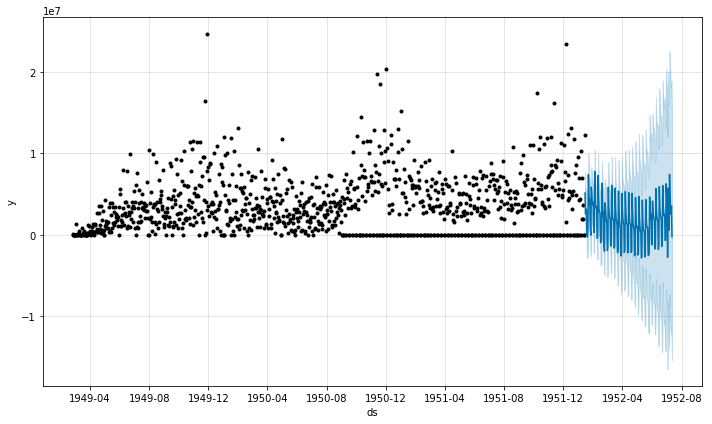

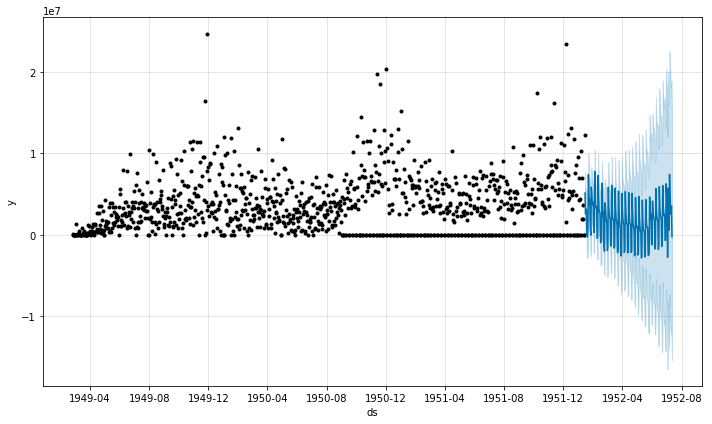

In [0]:
final_model.plot(final_forecast)

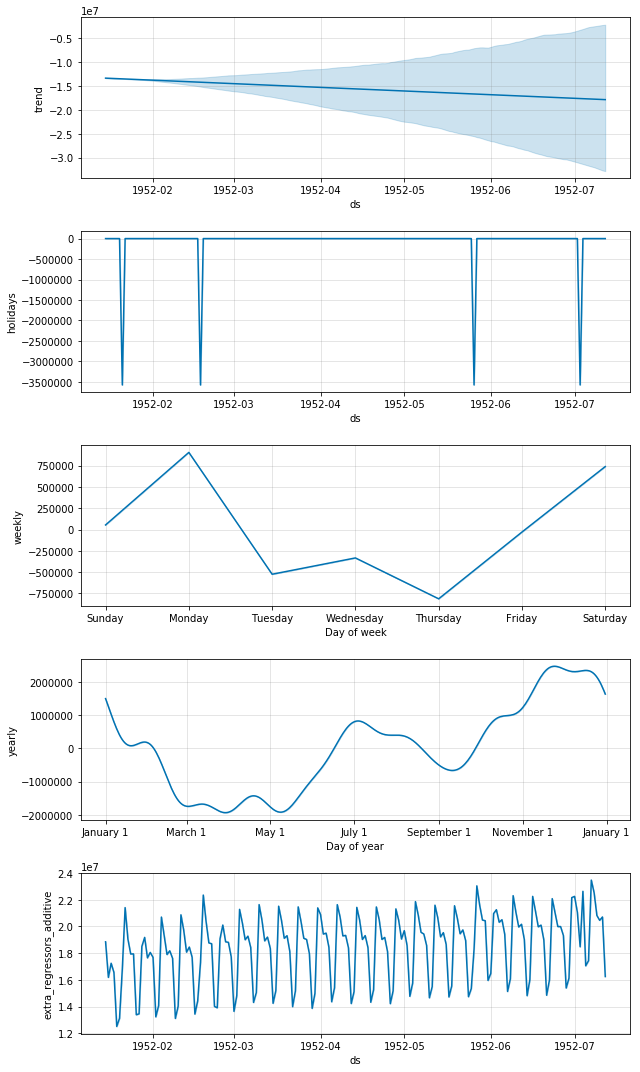

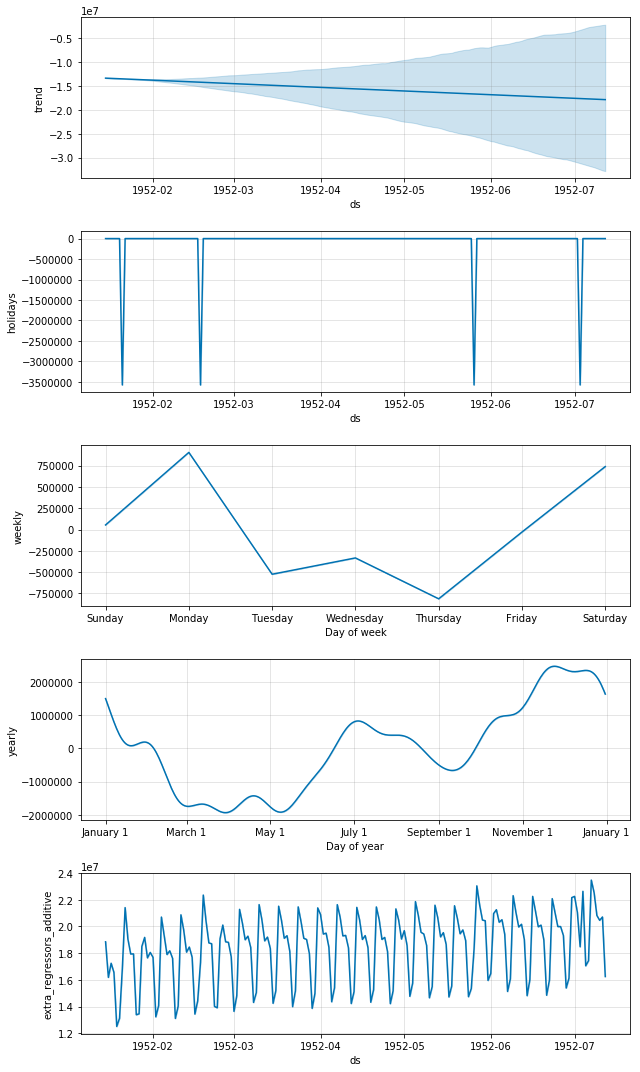

In [0]:
final_model.plot_components(final_forecast)

In [0]:
final['weekday'] = final['ds'].dt.dayofweek
final['is_weekend'] = np.where(final['weekday'] > 5, 1, 0)
final['yhat'] = np.where(final['is_weekend'] == 1, 0, final['yhat'])

final.drop(['weekday', 'is_weekend'], axis = 1, inplace = True)
final.head()

,ds,yhat
0,1952-01-15,5.134186e+06
1,1952-01-16,2.587902e+06
2,1952-01-17,3.109883e+06
3,1952-01-18,3.148261e+06
4,1952-01-19,-1.681980e+05


In [0]:
(final['yhat'] == 0).sum()

25

In [0]:
final['ds'].isin(holiday_list).sum()

4

In [0]:
final['yhat'] = np.where(final['ds'].isin(holiday_list), 0, final['yhat'])

In [0]:
(final['yhat'] == 0).sum()

29

In [0]:
final.shape

(180, 2)

In [0]:
final_forecast = final.tail(180)
final_forecast.reset_index(drop = True, inplace = True)
final_forecast.shape

(180, 2)

In [0]:
final_forecast.head()

,ds,yhat
0,1952-01-15,5.134186e+06
1,1952-01-16,2.587902e+06
2,1952-01-17,3.109883e+06
3,1952-01-18,3.148261e+06
4,1952-01-19,-1.681980e+05


In [0]:
final_forecast.to_csv('/content/model3_forecast.csv', index = False)

In [0]:
data3.shape, fc.shape

((891, 2), (891, 2))

In [0]:
data3.head()

,Effective Date,Amount
0,2005-02-25,131994.69
1,2005-03-01,16665.97
2,2005-03-03,1275375.80
3,2005-03-05,75407.50
4,2005-03-07,78310.72


In [0]:
final.head()

,ds,yhat
0,2005-02-25,1.820602e+06
1,2005-03-01,2.233541e+06
2,2005-03-03,1.126114e+06
3,2005-03-05,-9.022050e+05
4,2005-03-07,4.648404e+06


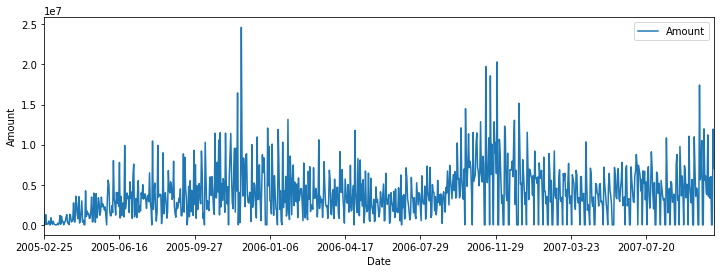

In [0]:
ax = data3.set_index('Effective Date').plot(figsize = (12, 4))
ax.set_ylabel('Amount')
ax.set_xlabel('Date')
plt.show()

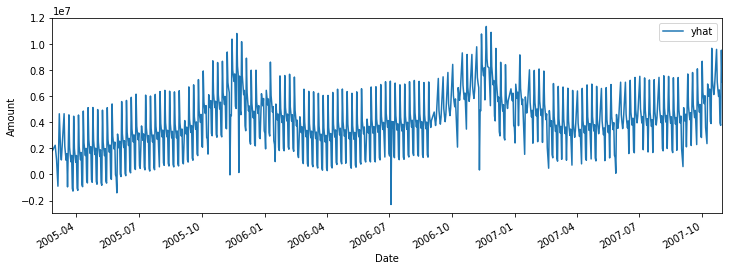

In [0]:
ax = fc.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Amount')
ax.set_xlabel('Date')
plt.show()